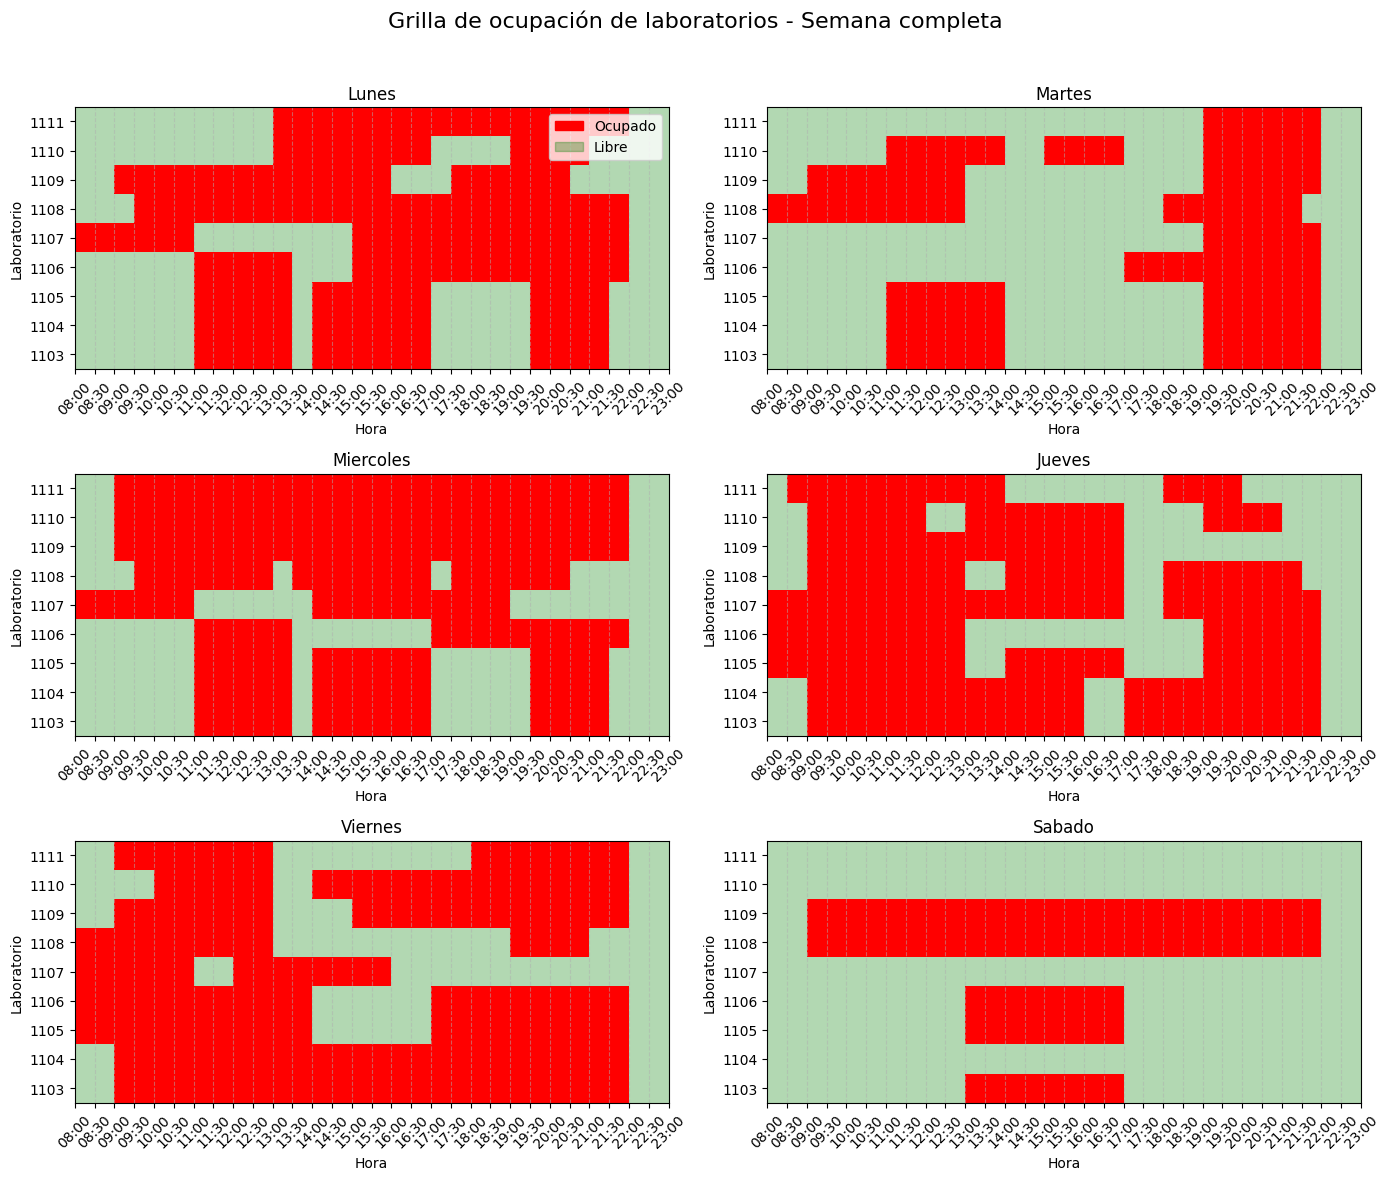

In [1]:
import csv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import requests
from io import StringIO

dias = ["Lunes", "Martes", "Miercoles", "Jueves", "Viernes", "Sabado"]
base_url = "https://raw.githubusercontent.com/ManuUBA/Horarios-zero/main/"
labos = list(range(1103, 1112))

def hora_a_decimal(hora):
    h, m = map(int, hora.split(':'))
    return h + m/60

def decimal_a_hora(dec):
    h = int(dec)
    m = int((dec - h) * 60)
    return f"{h:02d}:{m:02d}"

def obtener_horarios(url_csv):
    respuesta = requests.get(url_csv)
    archivo_csv = StringIO(respuesta.text)
    filas = list(csv.reader(archivo_csv, delimiter=','))
    header = [h.strip() for h in filas[1]]
    datos = filas[1:]
    c_aula   = header.index("Aula")
    c_desde  = header.index("Inicio")
    c_hasta  = header.index("Fin")
    c_pab    = header.index("Pab.")
    filas_labo = [f for f in datos if f[c_pab] == "0" and int(f[c_aula]) in labos]

    horarios_labo = []
    for aula in labos:
        tandas = [[f[c_desde], f[c_hasta]] for f in filas_labo if int(f[c_aula]) == aula]
        horarios_labo.append(tandas)
    return horarios_labo

# Crear figura con 6 subplots (2 columnas x 3 filas)
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, dia in enumerate(dias):
    ax = axes[idx]
    horarios_labo = obtener_horarios(f"{base_url}{dia}.csv")

    ax.set_xlim(8, 23)
    ax.set_ylim(0, len(labos))
    ax.set_yticks([i + 0.5 for i in range(len(labos))])
    ax.set_yticklabels([str(l) for l in labos])  # ahora se muestran todos los labos
    ax.set_xlabel("Hora")
    ax.set_ylabel("Laboratorio")

    # Dibujar bloques
    for jdx, aula in enumerate(horarios_labo):
        ax.add_patch(patches.Rectangle((8, jdx), 15, 1, facecolor='green', alpha=0.3))
        for inicio_str, fin_str in aula:
            inicio, fin = hora_a_decimal(inicio_str), hora_a_decimal(fin_str)
            ax.add_patch(patches.Rectangle((inicio, jdx), fin-inicio, 1, facecolor='red'))

    # Leyenda solo en el primer subplot
    if idx == 0:
        ax.legend([patches.Patch(color='red'), patches.Patch(color='green', alpha=0.3)],
                  ['Ocupado', 'Libre'], loc='upper right')

    ax.set_title(dia)

# Eje X cada media hora
marcas = [8 + 0.5*i for i in range((23-8)*2 + 1)]
for ax in axes:
    ax.set_xticks(marcas)
    ax.set_xticklabels([decimal_a_hora(m) for m in marcas], rotation=45)
    ax.grid(True, axis='x', linestyle='--', alpha=0.5)

plt.suptitle("Grilla de ocupación de laboratorios - Semana completa", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
plt.savefig("grafico.png")   # 👈 esto crea el archivo
plt.close()
